# Wavepackets dynamics on the Fibonacci chain.


We diagonalize the hamiltonian. Then we can compute the propagator
$$K_{ij}(t) = <j|\exp(-i H t)|i>$$

The probability to be at site j at time t, given that the wavepacket was dropped at site i initially is then simply
$$P_i(j;t) = |K_{ij}(t)|^2$$
The quadratic displacement from initial site $i$ is
$$P_i(t) = \sum_j (x_j - x_i)^2 P_i(j;t).$$
We can generalize to arbitrary moments of the position operator:
$$P_i(t;q) = \sum_j (x_j - x_i)^q P_i(j;t).$$
In the long-time limit, for the periodic infinite chain, we observe the power law behaviour
$$P_i(t;q) \sim t^{q}$$

For the quasiperiodic Fibonacci chain, we expect the long-time behaviour to be a power law modulated by an oscillating function which will become $\log$-periodic in the strong quasiperiodicity ($\rho \rightarrow 0$) limit. We write:
$$P_i(t;q) \sim F\left( \log t \right) t^{q \sigma_q}.$$
We expect $\sigma_q < 1$. 
Actually, we have stronger bounds on $\sigma_q$. Guarneri showed that the quadratic coefficient is larger than the information dimension of the spectral measure:
$$ \sigma_2 \geq D_1^\mu. $$
Ketzmerick et al exhibited a more precise lower bound involving the dimensions of the spectral measure and the dimensions of its support:
$$ \sigma_q \geq D_2^\mu/D_2. $$

Piéchon conjuctured that $ \sigma_q = D_{1-q} $, solely relating the power-law coefficient to the dimensions of the support of the spectral measure.

We use scipy linalg package to diagonalize the hamiltonian. We use the numpy.array structure for storage of the matrix.
(scipy.sparse.linalg.eigsh is designed for hamiltonian sparse matrices, which precisely what we have,
however it uses Lanczos algorithm, which typically only finds the highest eigenvalue with satisfying accuracy.)

In [1]:
import numpy as np
from scipy import linalg, stats
import matplotlib.pyplot as plt
import math
from cmath import exp
import time
%matplotlib inline

In [56]:
""" build the Fibonacci tight-binding hamiltonian """

# couplings
tw = 0.1
ts = 1.

# compute Fibonacci numbers
def fib(n):
    a, b = 0, 1
    for i in range(n):
        a, b = b, a + b
    return a

# inverse golden ratio
om = 2./(1.+math.sqrt(5))

# size
n = 8
L = fib(n)      

# jump amplitudes
def jump(i):
    fibi = int(om*(i+1)) - int(om*i) # an integer taking values 0 or 1 occordingly to Fibonacci sequence
    if(fibi < 1):return ts
    else:return tw

# build the hamiltonian (free boundary conditions)
h = np.zeros((L,L))
for i in range(L-1): 
    h[i,i+1] = jump(i+1)
    h[i+1,i] = h[i,i+1]
    
# construct the "band", to use eig_banded method
# there is 1 band above the diagonal, so a_band has shape (2,L)
a_band = np.zeros((2,L))
for i in range(L-1): a_band[0,i+1] = h[i,i+1]

# jump amplitudes
def jump(n, i, tw, ts):
    p = fib(n-2)    
    q = fib(n-1)
    L = fib(n)    
    if(i*q % L < p):return ts
    else:return tw
    
# build the hamiltonian (periodic boundary conditions)
def hp(n, rho):
    L = fib(n)    
    hp = np.zeros((L,L))
    for i in range(L-1): 
        hp[i,i+1] = jump(n, i, rho, 1.)
        hp[i+1,i] = hp[i,i+1]
        hp[0,L-1] = jump(n, L-1, rho, 1.)
        hp[L-1,0] = hp[0,L-1]
    return hp

In [114]:
""" compute the eigenvalues """

# eigensystem for a banded hermitian matrix (our case!)
n = 14
rho = .5
L = fib(n)
val, vec = linalg.eigh(hp(n, rho))

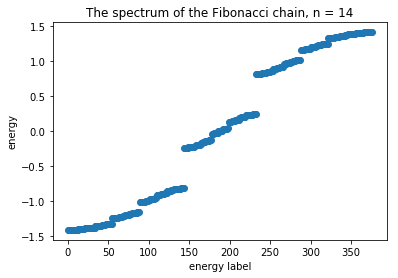

In [115]:
""" wow, such spectrum! much gaps! """

plt.title('The spectrum of the Fibonacci chain, n = ' + str(n))
plt.xlabel('energy label')
plt.ylabel('energy')
#plt.axis([0,L+1,-2.,2.])
plt.plot(val, 'o')
plt.show()

In [110]:
""" compute the propagator and the on-site presence probability """

# list of propagators in time t from position x
def K(t, x):
    psi0 = vec[x]
    expH = np.array([exp(- 1j*t*e) for e in val])
    return vec.dot(expH*psi0)

# list of on-site presence probabilities at time t, starting localized at site x
def I(t, x):
    psi0 = vec[x]
    expH = np.array([exp(- 1j*t*e) for e in val])
    return abs(vec.dot(expH*psi0))**2

In [111]:
""" timing tests """

start_time = time.time()
K(0,0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.001218557357788086 seconds ---


In [87]:
len(val)

377

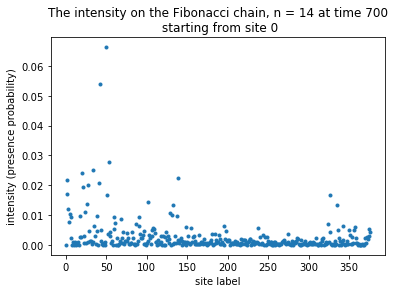

In [122]:
""" wow, such intensity! much spreading! """

x = 0
t = 700
plt.title('The intensity on the Fibonacci chain, n = '+str(n)+' at time '+str(t)+'\n starting from site '+str(x))
plt.xlabel('site label')
plt.ylabel('intensity (presence probability)')
#plt.axis([-1,L+1,-2.,2.])
plt.plot(I(t,x),'o',markersize=3.)
plt.show()

In [123]:
""" compute the q-average at time t, starting site orig """

def P(orig,t,q):
    dist = np.array([(np.minimum(abs(x-orig),L-abs(x-orig))/float(L))**q for x in range(L)])
    return dist.dot(I(t,orig))

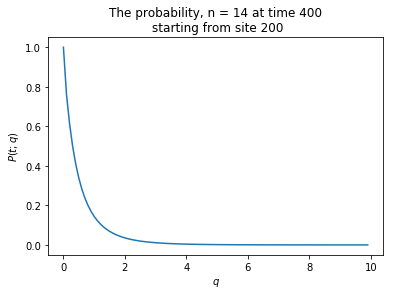

In [124]:
x = 200
t = 400
plt.title('The probability, n = '+str(n)+' at time '+str(t)+'\n starting from site '+str(x))
plt.xlabel(r'$q$')
plt.ylabel(r'$P(t;q)$')
qmin, qmax = 0., 10.
qs = np.arange(qmin, qmax, .1)
prob = [P(orig, t, q) for q in qs]
plt.plot(qs ,prob ,'-',markersize=3.)
plt.show()

In [125]:
tRange = 10**np.arange(-1,4,.001)
#tRange = np.arange(0,30,.2)
orig = 200
plist = [P(orig,t,2.) for t in tRange]

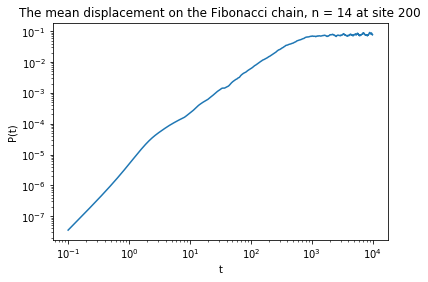

In [126]:
plt.title('The mean displacement on the Fibonacci chain, n = ' + str(n) + ' at site ' + str(orig))
plt.xlabel('t')
plt.ylabel('P(t)')
#plt.axis([0,L+1,-2.,2.])
plt.loglog(tRange, plist,'-',markersize=3.)
plt.show()

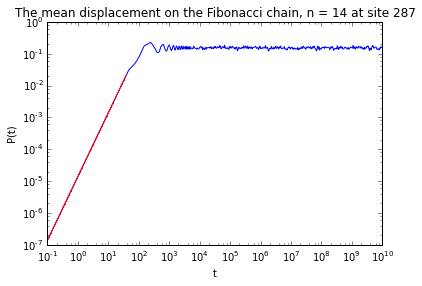

In [398]:
""" Lineart regression of the data """

logtRange = np.arange(-1,1.6,.02)
tRange2 = 10**logtRange
plist2 = [P(orig,t,2.) for t in tRange2]

plt.title('The mean displacement on the Fibonacci chain, n = ' + str(n) + ' at site ' + str(orig))
plt.xlabel('t')
plt.ylabel('P(t)')
#plt.axis([0,L+1,-2.,2.])
plt.loglog(tRange, plist,'-',markersize=3.)
plt.loglog(tRange2, plist2,'-,r',markersize=3.)
plt.show()

# data in log-log scale
logP = [math.log(p) for p in plist2]
logT = [math.log(t) for t in tRange2]

slope, intercept, r_value, p_value, std_err = stats.linregress(logT,logP)

In [399]:
slope, r_value

(1.9999999999658185, 0.99999999999999956)